# 概要
下記のコードをベースとして、LSTM、BiLSTM、attentionを使ったNMTモデルを構築し、BLEUスコアを算出する。
https://www.tensorflow.org/tutorials/text/nmt_with_attention

本ノートブックはそのうちBiLSTMを実装したものになる。

# 処理の流れ
0. 環境構築
1. データのロード
2. データの前処理
3. モデルの定義
    1. encoder
    2. attention
    3. decorder
4. BLEUスコア評価用関数の定義
5. 学習
6. attentionの可視化

# 前提
課題であるsmall_parallel_enjaをgit cloneしたものを同じディレクトリに置く。

# 0. 環境構築
本ノートブックはAWS Sagemakerのノートブックインスタンスでの動作を想定している。
* kernel: conda_tensorflow_p36
* instance type: ml.p2.xlarge(学習時), ml.t2.medium(開発時)


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
print(tf.__version__)

1.15.0


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12917984367299676993, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17933501727488648493
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12242937410948615564
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3015438579864934307
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [4]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

下記を確認する。
* print(tf.\_\_version\_\_)の出力が1.15.0であること
* 学習を行う場合はdevice_lib.list_local_devices()の出力にGPUが含まれること
* tf.executing_eagerly()がTrueになっており、eager executionが可能になっていること

# 1. データのロード
* 前提として、ノートブックと課題であるsmall_parallel_enjaをgit cloneしたものを同じディレクトリに置く。

In [5]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
en_sentence = "i can 't tell who will arrive first ."
ja_sentence = "誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ja_sentence))

<start> i can 't tell who will arrive first . <end>
<start> 誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。 <end>


In [7]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [8]:
# データの読み込み
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [9]:
en[0:10]

["<start> i can 't tell who will arrive first . <end>",
 '<start> many animals have been destroyed by men . <end>',
 "<start> i 'm in the tennis club . <end>",
 '<start> emi looks happy . <end>',
 '<start> please bear this fact in mind . <end>',
 '<start> she takes care of my children . <end>',
 '<start> we want to be international . <end>',
 '<start> you ought not to break your promise . <end>',
 '<start> when you cross the street , watch out for cars . <end>',
 '<start> i have nothing to live for . <end>']

# 2. データの前処理
通常、言語データを時系列データとして解析する際は、以下のようなステップをたどる
1. 文字列の読み込み
2. 単語単位への分解
3. 単語へのID割り振り
4. 単語列からIDの羅列への変換

今回のデータセットは単語単位への分解がすでに終わっているので省略できる。

In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [13]:
# 単語へのIDの割り振りとID列への変換
# このサイズのデータセットで実験
num_examples = None
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [14]:
max_length_targ

18

In [15]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [16]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [17]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
10 ----> he
1598 ----> regarded
5 ----> the
227 ----> story
39 ----> as
11 ----> a
832 ----> joke
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
15 ----> 彼
5 ----> は
27 ----> その
61 ----> 話
9 ----> を
757 ----> 冗談
23 ----> だ
25 ----> と
139 ----> 考え
8 ----> た
4 ----> 。
3 ----> <end>


# 3. モデルの定義

データの処理の流れは下記
1. Encorderで入力をhidden stateに変換
    1. 入力された単語IDをembedding
    2. BiLSTMでhidden stateに変換
2. Decorderで文字列として出力
    1. 前時刻のdecorder outputとhidden stateをLSTMでhidden stateに変換(こちら側は一方通行のLSTM)
    2. 全結合層で単語に出力

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(128), Dimension(18)]),
 TensorShape([Dimension(128), Dimension(18)]))

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units//2
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.Bidirectional(
                             tf.keras.layers.LSTM(self.enc_units,
                                                   return_sequences=False,
                                                   return_state=True,
                                                   recurrent_initializer='glorot_uniform')
                             ,merge_mode='concat')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, f_memory, f_state, b_memory, b_state = self.lstm(x, initial_state = hidden)
        return output, f_memory, f_state, b_memory, b_state

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)),]

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [22]:
# サンプル入力
sample_f_memory, sample_f_state, sample_b_memory, sample_b_state = encoder.initialize_hidden_state()
sample_output, sample_f_memory, sample_f_state, sample_b_memory, sample_b_state = encoder(example_input_batch, [sample_f_state, sample_f_memory, sample_b_state, sample_b_memory])
print ('Encoder output shape: (batch size, units) {}'.format(sample_output.shape))
print ('Encoder f-memory shape: (batch size, units) {}'.format(sample_f_memory.shape))
print ('Encoder f-hidden state shape: (batch size, units) {}'.format(sample_f_state.shape))

Encoder output shape: (batch size, units) (128, 1024)
Encoder f-memory shape: (batch size, units) (128, 512)
Encoder f-hidden state shape: (batch size, units) (128, 512)


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
                            
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        #self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        #context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        #x = tf.concat([tf.expand_dims(hidden, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, memory, state = self.lstm(x, initial_state = hidden)

        # output shape == (batch_size * 1, hidden_size)
        #output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, memory, state

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [25]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((128, 1)), [tf.concat([sample_f_state,sample_b_state],axis=1), tf.zeros((BATCH_SIZE, units))])

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 8778)


In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

学習途中段階のモデルはS3に保存した。

In [27]:
checkpoint_dir = 's3://e-qual-task/0202-BiLSTM/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [28]:
checkpoint_prefix

's3://e-qual-task/0202-BiLSTM/ckpt'

In [29]:
@tf.function
def train_step(inp, targ, enc_f_hidden, enc_f_memory, enc_b_hidden, enc_b_memory):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_f_memory, enc_f_hidden, enc_b_memory, enc_b_hidden = encoder(inp, [enc_f_hidden, enc_f_memory, enc_b_hidden, enc_b_memory])

        dec_hidden = tf.concat([enc_f_hidden, enc_f_hidden], axis=1)

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        dec_memory = tf.zeros((BATCH_SIZE, units))

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_memory, dec_hidden = decoder(dec_input, [dec_hidden, dec_memory])

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

# 4. BLEUスコア評価用関数の定義
1. NMTモデルを使って英→日の翻訳
2. テストデータを使ってモデルの評価

In [30]:
def evaluate(sentence):
    #attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = []
    for i in sentence.split(' '):
        try:
            inputs.append(inp_lang.word_index[i])
        except KeyError:
            inputs.append(inp_lang.word_index['<unk>'])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    f_hidden = tf.zeros((1, units//2))
    f_memory = tf.zeros((1, units//2))
    b_hidden = tf.zeros((1, units//2))
    b_memory = tf.zeros((1, units//2))
    #inputs = tf.expand_dims(inputs,0)
    enc_output, enc_f_memory, enc_f_hidden, enc_b_memory, enc_b_hidden = encoder(inputs, [f_hidden, f_memory, b_hidden, b_hidden])

    dec_hidden = tf.concat([enc_f_hidden, enc_b_hidden],axis=1)
    #return dec_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    dec_memory = tf.zeros((1, units))


    for t in range(max_length_targ):
        predictions, dec_memory, dec_hidden = decoder(dec_input, [dec_hidden, dec_memory])
        '''
        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        '''

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [31]:
def translate(sentence):
    result, sentence= evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [32]:
# 評価用にtestデータをロードしておく
path_test_en = 'small_parallel_enja/test.en'
with open(path_test_en) as f:
    en_test = f.readlines()
en_test = [w.rstrip().strip() for w in en_test]
    
path_test_ja = 'small_parallel_enja/test.ja'
with open(path_test_ja) as f:
    ja_test = f.readlines()
ja_test = [w.rstrip().strip() for w in ja_test]
ja_test = ja_test[:100]
# BLEUのライブラリのインプットにデータ形式をあわせる
ja_test_l = [sentence.split() for sentence in ja_test]

In [33]:
# 学習中に呼び出してモニタリングするために関数化
def calc_BLEU(pred_l,test_l):
    score = [sentence_bleu([reference], candidate) for reference, candidate in zip(test_l,pred_l )]
    return np.mean(score)

In [34]:
# BLEUの警告がうるさいので静かにさせる
import warnings
warnings.simplefilter('ignore')

# 5. 学習
学習は20エポック行う。

In [35]:
EPOCHS = 20
stats = dict.fromkeys(('Epoch','Loss','BLEU'))
stats['Epoch'], stats['Loss'], stats['BLEU'] = [], [], []
BLEU_score = 0

for epoch in range(EPOCHS):
    start = time.time()

    enc_f_hidden, enc_f_memory, enc_b_hidden, enc_b_memory = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_f_hidden, enc_f_memory, enc_b_hidden, enc_b_memory)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # 5 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    # エポックごとにBLEUスコアを評価
    ja_pred = [evaluate(sentence)[0] for sentence in en_test[:100]]
    ja_pred_l = [sentence.split() for sentence in ja_pred]
    BLEU_score = calc_BLEU(ja_pred_l, ja_test_l)
    
    print('Epoch {} Loss {:.4f} BLEU score {:.4f}'.format(epoch + 1,
                                                          total_loss / steps_per_epoch,
                                                          BLEU_score))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    stats['Epoch'].append(epoch + 1)
    stats['Loss'].append(total_loss / steps_per_epoch)
    stats['BLEU'].append(BLEU_score)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 6.3174
Epoch 1 Batch 100 Loss 3.0940
Epoch 1 Batch 200 Loss 2.7646
Epoch 1 Batch 300 Loss 2.5085
Epoch 1 Loss 2.9730 BLEU score 0.0075
Time taken for 1 epoch 195.57149648666382 sec

Epoch 2 Batch 0 Loss 2.5630
Epoch 2 Batch 100 Loss 2.3111
Epoch 2 Batch 200 Loss 2.2987
Epoch 2 Batch 300 Loss 2.1960
Epoch 2 Loss 2.3174 BLEU score 0.0046
Time taken for 1 epoch 129.86896085739136 sec

Epoch 3 Batch 0 Loss 2.2687
Epoch 3 Batch 100 Loss 2.1035
Epoch 3 Batch 200 Loss 2.1556
Epoch 3 Batch 300 Loss 2.0708
Epoch 3 Loss 2.1409 BLEU score 0.0046
Time taken for 1 epoch 130.2858588695526 sec

Epoch 4 Batch 0 Loss 2.1603
Epoch 4 Batch 100 Loss 2.0073
Epoch 4 Batch 200 Loss 2.0657
Epoch 4 Batch 300 Loss 2.0007
Epoch 4 Loss 2.0525 BLEU score 0.0036
Time taken for 1 epoch 133.3902087211609 sec

Epoch 5 Batch 0 Loss 2.0879
Epoch 5 Batch 100 Loss 1.9481
Epoch 5 Batch 200 Loss 2.0061
Epoch 5 

In [40]:
evaluate(en_test[8])[0]

'彼 は その 問題 を 解 く の に は な い 。 <end> '

In [41]:
en_test[8]

'we have this game on ice .'

In [42]:
checkpoint.save('ckpt/ckpt_0202/BiLSTM/')

'ckpt/ckpt_0202/BiLSTM/-5'

In [44]:
import pandas as pd
df = pd.DataFrame(stats)
df['Loss'] = df['Loss'].map(lambda x:x.numpy())
df.to_csv('BiLSTM-0202.csv',index=False)

# 6 評価と可視化
得られたスコアをプロット

In [38]:
# checkpoint_dir の中の最後のチェックポイントを復元
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint('ckpt/ckpt_0201/LSTM'))

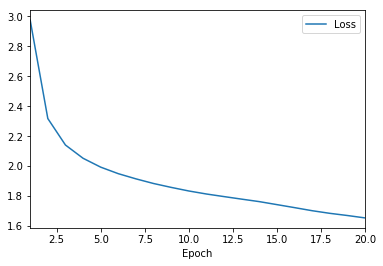

In [45]:
df[['Loss','Epoch']].plot('Epoch')

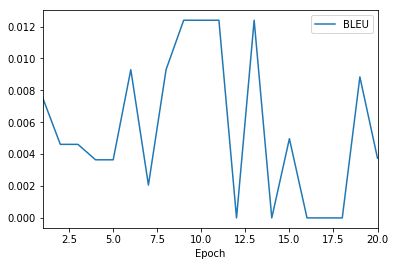

In [46]:
df[['BLEU','Epoch']].plot('Epoch')